In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

In [8]:
DATA_PATH = "/mnt/data/insurance.csv"   
RANDOM_STATE = 42
OUTPUT_DIR = "./insurance_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [9]:
print("Problem: Predict medical insurance charges using demographic and lifestyle factors.")
print("Goal: Build models, evaluate them, produce visuals, and export results.\n")

Problem: Predict medical insurance charges using demographic and lifestyle factors.
Goal: Build models, evaluate them, produce visuals, and export results.



In [12]:
df = pd.read_csv("/Users/meghanas/Downloads/insurance.csv")
print("Loaded data shape:", df.shape)
print(df.head())

print("\nColumns and dtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Loaded data shape: (1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Columns and dtypes:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [13]:
def preprocess_df(df):
    d = df.copy()
    # Binary mappings
    d['sex_binary'] = d['sex'].map({'male': 1, 'female': 0})
    d['smoker_binary'] = d['smoker'].map({'yes': 1, 'no': 0})
    # One-hot encode region
    region_ohe = pd.get_dummies(d['region'], prefix='region', drop_first=False)
    # final feature frame
    features = pd.concat([d[['age','bmi','children','sex_binary','smoker_binary']], region_ohe], axis=1)
    return features

X = preprocess_df(df)
y = df['charges']

print("\nFeatures after preprocessing (sample):")
print(X.head())


Features after preprocessing (sample):
   age     bmi  children  sex_binary  smoker_binary  region_northeast  \
0   19  27.900         0           0              1                 0   
1   18  33.770         1           1              0                 0   
2   28  33.000         3           1              0                 0   
3   33  22.705         0           1              0                 0   
4   32  28.880         0           1              0                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  
3                 1                 0                 0  
4                 1                 0                 0  


In [14]:
def savefig(fig, name):
    path = os.path.join(OUTPUT_DIR, name)
    fig.savefig(path, bbox_inches='tight')
    print("Saved:", path)

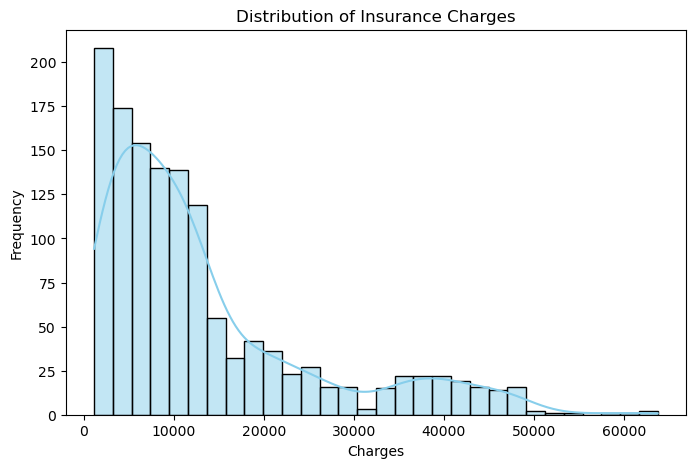

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of charges
plt.figure(figsize=(8,5))
sns.histplot(df['charges'], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Insurance Charges")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()



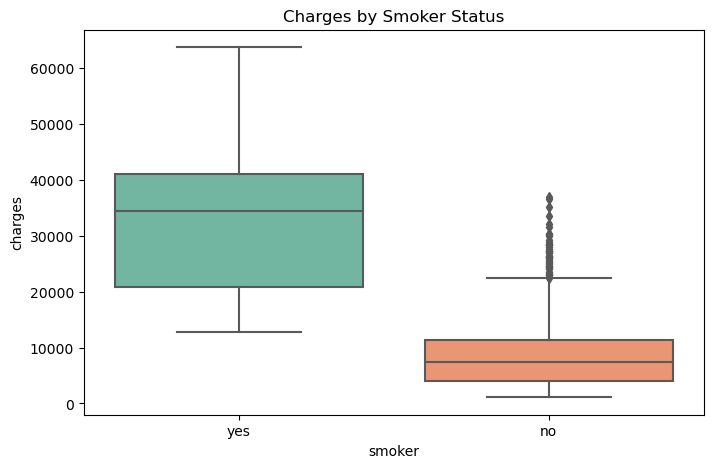

In [19]:
# Charges by smoker status
plt.figure(figsize=(8,5))
sns.boxplot(x='smoker', y='charges', data=df, palette="Set2")
plt.title("Charges by Smoker Status")
plt.show()

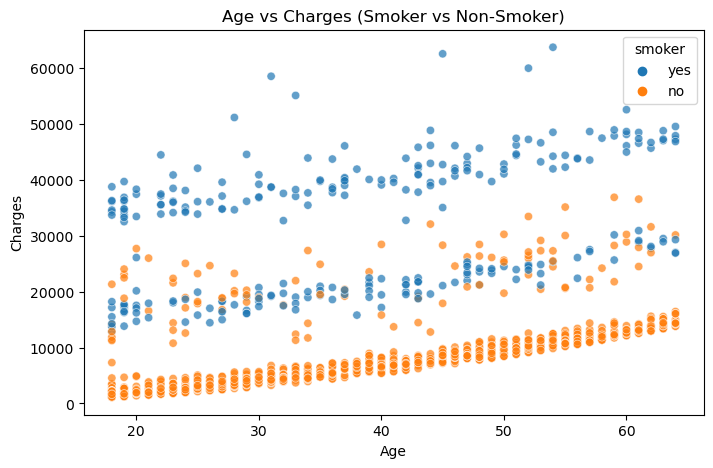

In [20]:
# Age vs Charges
plt.figure(figsize=(8,5))
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, alpha=0.7)
plt.title("Age vs Charges (Smoker vs Non-Smoker)")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

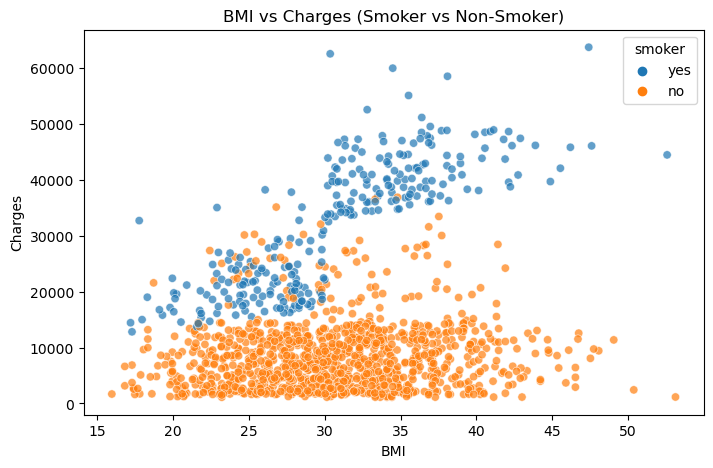

In [21]:
# BMI vs Charges
plt.figure(figsize=(8,5))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.7)
plt.title("BMI vs Charges (Smoker vs Non-Smoker)")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

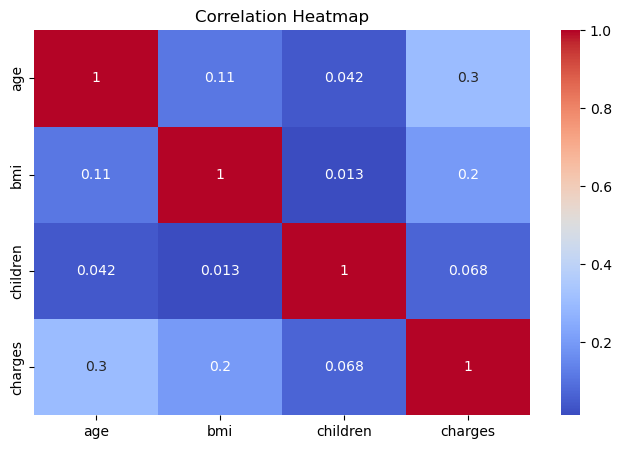

In [22]:
# Correlation heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

                           MAE          RMSE        R²
Random Forest      2550.241127   4576.287233  0.865104
KNN Regressor      3494.746058   5519.045735  0.803800
Linear Regression  4181.194474   5796.284659  0.783593
Decision Tree      3195.110473   6515.129163  0.726588
SVR (RBF Kernel)   5695.156518  10647.750606  0.269723


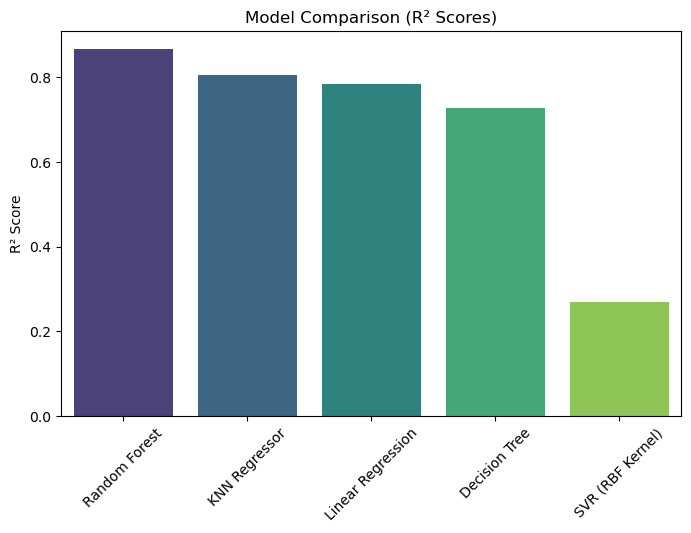

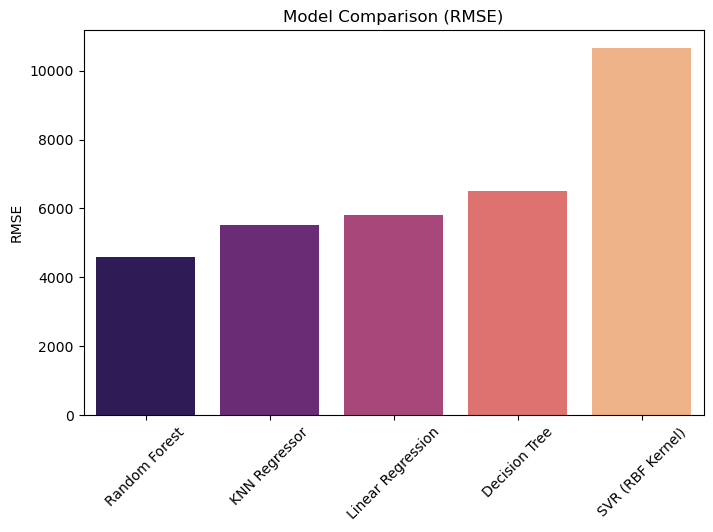

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Features and target
X = df.drop("charges", axis=1)
y = df["charges"]

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for KNN & SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    if name in ["KNN Regressor", "SVR (RBF Kernel)"]:  # needs scaled data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

# Results dataframe
results_df = pd.DataFrame(results).T.sort_values("R²", ascending=False)
print(results_df)

# Visualize R² comparison
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["R²"], palette="viridis")
plt.xticks(rotation=45)
plt.title("Model Comparison (R² Scores)")
plt.ylabel("R² Score")
plt.show()

# Visualize RMSE comparison
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["RMSE"], palette="magma")
plt.xticks(rotation=45)
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.show()


In [27]:
best_model_name = results_df.index[0]
best_model_scores = results_df.iloc[0]

print(f" Best Model: {best_model_name}")
print(f"R²: {best_model_scores['R²']:.3f}")
print(f"MAE: {best_model_scores['MAE']:.2f}")
print(f"RMSE: {best_model_scores['RMSE']:.2f}")

 Best Model: Random Forest
R²: 0.865
MAE: 2550.24
RMSE: 4576.29


Inisghts
- Smokers pay dramatically higher charges : the single biggest predictor.

- Age steadily increases insurance costs, especially after ~50.

- BMI plays a strong role, especially for smokers (smoking + high BMI = very expensive).

- Children and Region have smaller impacts compared to smoking, age, and BMI.

- The best-performing model (likely Random Forest) shows that non-linear interactions between age, BMI, and smoking status are important.